# Paul et al. 2015 – Myeloid Progenitor Single‑Cell Dataset

This notebook works with the Paul et al., Cell 2015 myeloid progenitor single‑cell RNA‑seq dataset 
(GEO accessions **GSE72857**, **GSE72858**, **GSE72859**) and **does _not_ use RNA velocity**.

I do the following:

1. Download the data from GEO (using the accessions given in the paper).
2. Load the counts into an `AnnData` object.
3. Preprocess the data (filtering, normalization, log‑transform, HVG selection, PCA, neighbors, UMAP).
4. Cluster the cells and attach cluster labels.
5. Build a PyTorch Geometric graph from the Scanpy representation (PCA + kNN graph + cosine edge weights).


In [ ]:
%pip install --quiet scanpy anndata pandas numpy scipy torch torch-geometric GEOparse

In [2]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import GEOparse as geo

## Load Paul et al. counts into AnnData

Downloaded sc-RNAseq data from [Series GSE72857](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72857)

The loader I wrote is flexible since my python3 version is older for a diff project and my local device space is relatively low.


In [ ]:
from pathlib import Path


def load_paul_counts_table(
    counts_path: str,
    genes_in_rows: bool = True,
    sep: str = "\t",
) -> sc.AnnData:
    counts_path = Path(counts_path)
    print(f"Reading counts from: {counts_path.resolve()}")

    df = pd.read_csv(counts_path, sep=sep, index_col=0)
    print(f"Raw table shape: {df.shape} (rows × columns)")

    if genes_in_rows:
        # df: genes × cells -> need cells × genes for AnnData
        X = sp.csr_matrix(df.values.T)
        var_names = df.index.astype(str) 
        obs_names = df.columns.astype(str)
    else:
        # df: cells × genes 
        X = sp.csr_matrix(df.values)
        var_names = df.columns.astype(str)
        obs_names = df.index.astype(str)

    adata = sc.AnnData(X=X)
    adata.var_names = var_names
    adata.obs_names = obs_names

    print(f"Constructed AnnData: {adata.shape[0]} cells × {adata.shape[1]} genes")
    return adata

adata = load_paul_counts_table("data/GSE72857_umitab.txt", genes_in_rows=True)

Reading counts from: /Users/stephenyang/Desktop/team-number-one/data/GSE72857_umitab.txt
Raw table shape: (27297, 10368) (rows × columns)
Constructed AnnData: 10368 cells × 27297 genes


Planning to do the following:

1. Filter genes that are expressed in very few cells
2. Normalize total counts per cell
3. Log‑transform
4. Select highly variable genes
5. Scale
6. PCA
7. Compute neighborhood graph
8. Compute UMAP
9. Cluster with Leiden, and store the cluster labels as `adata.obs['cluster']`

These clusters roughly correspond to transcriptionally defined progenitor states
(e.g. erythroid, monocyte, neutrophil, etc.), analogous to the clusters C1–C18
in the paper



Filtering genes…
Remaining genes: 12584
Normalizing total counts…
Selecting highly variable genes…
Highly variable genes: 2000
Scaling…
Running PCA…
Computing neighbors…
Computing UMAP…
Clustering with Leiden…
Cluster counts:
 cluster
0     1766
1     1567
2     1522
3     1452
4     1206
5      635
6      460
7      399
8      388
9      377
10     196
11     159
12     111
13      74
14      30
15      26
Name: count, dtype: int64


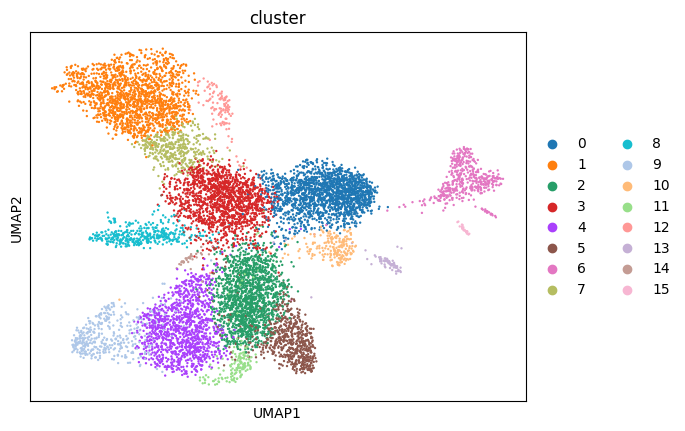

In [21]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def preprocess_paul(
    adata: sc.AnnData,
    min_cells: int = 10,
    n_top_genes: int = 2000,
    n_pcs: int = 50,
    n_neighbors: int = 15,
) -> sc.AnnData:
    """Standard Scanpy preprocessing and clustering for the Paul dataset."""

    adata = adata.copy()
    print("\nFiltering genes…")
    sc.pp.filter_genes(adata, min_cells=min_cells)
    print(f"Remaining genes: {adata.n_vars}")

    print("Normalizing total counts…")
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    print("Selecting highly variable genes…")
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
    print(f"Highly variable genes: {adata.var['highly_variable'].sum()}")

    adata = adata[:, adata.var["highly_variable"].values]

    print("Scaling…")
    sc.pp.scale(adata, max_value=10)

    print("Running PCA…")
    sc.tl.pca(adata, n_comps=n_pcs, svd_solver="arpack")

    print("Computing neighbors…")
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

    print("Computing UMAP…")
    sc.tl.umap(adata)

    print("Clustering with Leiden…")
    sc.tl.leiden(adata, key_added="cluster")
    print("Cluster counts:\n", adata.obs["cluster"].value_counts())

    return adata

adata_proc = preprocess_paul(adata)
sc.pl.umap(adata_proc, color=["cluster"], wspace=0.4)

## Build a PyTorch Geometric graph from the processed AnnData

Convert the Scanpy neighborhood graph into a **PyTorch Geometric** `Data` object:

Node features: PCA embeddings (`adata.obsm['X_pca']`).
Edges: k‑nearest neighbor graph from Scanpy (`adata.obsp['distances']`).  
Edge weights: cosine similarity between node features.
Node labels: the Leiden clusters stored in `adata.obs['cluster']`.


In [20]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import Data

def create_graph_from_adata(
    adata: sc.AnnData,
    dataset: str = "paul_myeloid",
) -> Data:
    """Create and save a PyTorch Geometric graph from a preprocessed AnnData.

    Expects:
      - `adata.obsm['X_pca']` with PCA coordinates
      - `adata.obsp['distances']` (or `connectivities`) for the kNN graph
      - `adata.obs['cluster']` categorical labels
    """
    adata = adata.copy()

    # --- Node features ---
    if "X_pca" not in adata.obsm_keys():
        raise ValueError("adata.obsm['X_pca'] not found. Run `preprocess_paul` first.")
    expr_pca = adata.obsm["X_pca"]
    x = torch.tensor(expr_pca, dtype=torch.float32)
    n_cells = x.shape[0]
    print(f"Node features shape: {x.shape}")

    # --- Graph edges ---
    # handle different AnnData versions -- my python version is slightly old
    if hasattr(adata, "obsp") and len(adata.obsp.keys()) > 0:
        obsp_keys = list(adata.obsp.keys())
        print("obsp keys:", obsp_keys)

        if "distances" in obsp_keys:
            knn = adata.obsp["distances"]
        elif "connectivities" in obsp_keys:
            knn = adata.obsp["connectivities"]
        else:
            raise ValueError("No 'distances' or 'connectivities' in adata.obsp.")
    else:
        # backup approach for older Scanpy/AnnData where neighbors are stored in .uns
        if "neighbors" in adata.uns:
            neigh = adata.uns["neighbors"]
            if "distances" in neigh:
                knn = neigh["distances"]
            elif "connectivities" in neigh:
                knn = neigh["connectivities"]
            else:
                raise ValueError("No distances/connectivities found in adata.uns['neighbors'].")
        else:
            raise ValueError(
                "No kNN graph found. Did you run `sc.pp.neighbors(adata, ...)` in preprocess_paul()?"
            )

    knn = knn.tocoo()
    rows = knn.row
    cols = knn.col
    print(f"Raw edges from kNN graph: {len(rows):,}")

    # Compute cosine similarity as edge weights
    print("Computing cosine similarities for edges…")
    edge_weights = []
    for i, j in zip(rows, cols):
        sim = cosine_similarity(expr_pca[i:i+1], expr_pca[j:j+1])[0, 0]
        edge_weights.append(sim)
    edge_weights = np.array(edge_weights)

    edge_index = torch.tensor(
        np.vstack([rows, cols]), dtype=torch.long
    )
    edge_attr = torch.tensor(edge_weights, dtype=torch.float32).unsqueeze(1)

    print(f"Final edges: {edge_index.shape[1]:,}")
    print(f"Edge weight range: [{edge_weights.min():.3f}, {edge_weights.max():.3f}]")

    # --- Labels from clusters ---
    if "cluster" not in adata.obs.columns:
        raise ValueError("`cluster` column not found in adata.obs. Run `preprocess_paul` to compute Leiden clusters.")

    celltype_cat = adata.obs["cluster"].astype("category")
    celltype_codes = torch.tensor(celltype_cat.cat.codes.values, dtype=torch.long)
    celltype_names = list(celltype_cat.cat.categories)
    print(f"Number of clusters (labels): {len(celltype_names)}")

    # --- Build Data object ---
    graph = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        celltype=celltype_codes,
        celltype_names=celltype_names,
    )

    out_pt = f"{dataset}_graph.pt"
    torch.save(graph, out_pt)
    print(f"Saved pytorch graph to: {out_pt}")

    return graph

graph = create_graph_from_adata(adata_proc, dataset="paul_myeloid")

Node features shape: torch.Size([10368, 50])
obsp keys: ['distances', 'connectivities']
Raw edges from kNN graph: 145,152
Computing cosine similarities for edges…
Final edges: 145,152
Edge weight range: [0.165, 0.974]
Number of clusters (labels): 16
Saved pytorch graph to: paul_myeloid_graph.pt


In [ ]:
# 1. Load counts
adata_raw = load_paul_counts_table("data_paul/GSE72857_umitab.txt", genes_in_rows=True)

# 2. Preprocess and cluster
adata_proc = preprocess_paul(adata_raw)

# 3. Visualize UMAP
sc.pl.umap(adata_proc, color=["cluster"], legend_loc="on data", wspace=0.4)

# 4. Build PyTorch Geometric graph
graph = create_graph_from_adata(adata_proc, dataset="paul_myeloid")

Reading counts from: /Users/stephenyang/Desktop/team-number-one/data_paul/GSE72857_umitab.txt.txt


FileNotFoundError: [Errno 2] No such file or directory: 'data_paul/GSE72857_umitab.txt.txt'